### Imports

In [6]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os


from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier
from art.utils import load_mnist

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [15]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

# Create dataloaders

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single =  DataLoader(test_dataset, batch_size=1)

### Inputs

In [55]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
path = Path("C:/Users/Matach/Documents/Imperial College London/FYP/saved_models/MNIST/FGSM/FGSM Adversarial/model_ART")
file = "epsilon_03_2.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

### Model under attack

In [56]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 512)
        self.fc2 = nn.Linear(512, 200)
        self.fc3 = nn.Linear(200,10)
        

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Classifier().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Classifier(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)
Accuracy on benign test examples: 98.78 %


### Carlini

In [57]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)

    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

### L2

In [58]:
carlini_l2 = dict()
constants = [0.1, 0.5, 1.0, 2.5, 5, 10]
n = 1000
accuracies = []
distances = []
for init in constants:
    x_test_adv = CarliniL2(classifier, x_test[:n], init_const=init)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))
    dist = L2distance(x_test[:n], x_test_adv)
    distances.append(round(dist, 3))

    print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

c: 0.1  Accuracy: 0.979  Distance: 0.204
c: 0.5  Accuracy: 0.835  Distance: 1.278
c: 1.0  Accuracy: 0.589  Distance: 1.953
c: 2.5  Accuracy: 0.213  Distance: 2.717
c: 5  Accuracy: 0.088  Distance: 3.122
c: 10  Accuracy: 0.057  Distance: 3.412


In [59]:
accuracies

[0.979, 0.835, 0.589, 0.213, 0.088, 0.057]

In [60]:
distances

[0.204, 1.278, 1.953, 2.717, 3.122, 3.412]

### LInf

In [61]:
epsilons = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
n = 1000
accuracies = []
for eps in epsilons:
    x_test_adv = CarliniLInf(classifier, x_test[:n], epsilon=eps)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))

    print('eps:', eps, ' Accuracy:', acc)

print(accuracies)

eps: 0.01  Accuracy: 0.985
eps: 0.1  Accuracy: 0.913
eps: 0.2  Accuracy: 0.781
eps: 0.3  Accuracy: 0.523
eps: 0.4  Accuracy: 0.348
eps: 0.5  Accuracy: 0.198
eps: 0.6  Accuracy: 0.104
[0.985, 0.913, 0.781, 0.523, 0.348, 0.198, 0.104]


## Results

In [51]:
adv_fgsm_train = {
    'No adversarial training': [0.973 , 0.78966667, 0.532 , 0.212 , 0.10633333, 0.06433333],
    'Epsilon = 0.1': [0.969, 0.837, 0.585, 0.208, 0.075, 0.055],
    'Epsilon = 0.2': [0.97, 0.832, 0.631, 0.244, 0.082, 0.049],
    'Epsilon = 0.3': [0.974, 0.842, 0.583, 0.178, 0.071, 0.057],
    'Epsilon = 0.4': [0.97, 0.817, 0.587, 0.183, 0.07, 0.053],
    'Epsilon = 0.5': [0.975, 0.833, 0.55, 0.177, 0.068, 0.056],
    'Epsilon = 0.6': [0.977, 0.84, 0.607, 0.233, 0.084, 0.056],
}

adv_fgsm_dist = {
    'No adversarial training': [0.271, 1.275, 2.017, 2.692, 3.117, 3.46],
    'Epsilon = 0.1':[0.2, 1.057, 1.925, 2.682, 3.115, 3.349],
    'Epsilon = 0.2': [0.231, 1.15, 1.803, 2.784, 3.26, 3.56],
    'Epsilon = 0.3': [0.173, 1.125, 1.948, 2.803, 3.138, 3.374],
    'Epsilon = 0.4': [0.282, 1.212, 1.852, 2.756, 3.101, 3.325],
    'Epsilon = 0.5': [0.215, 1.208, 2.069, 2.778, 3.12, 3.395],
    'Epsilon = 0.6': [0.24, 1.148, 1.891, 2.77, 3.268, 3.535],
}

adv_fgsm_eps = {
    'No adversarial training': [0.987, 0.929, 0.780, 0.568, 0.368, 0.197, 0.108],
    'Epsilon = 0.1': [0.983, 0.9, 0.746, 0.516, 0.311, 0.169, 0.092],
    'Epsilon = 0.2': [0.985, 0.916, 0.768, 0.587, 0.385, 0.231, 0.115],
    'Epsilon = 0.3': [0.981, 0.923, 0.764, 0.51, 0.327, 0.183, 0.093],
    'Epsilon = 0.4': [0.981, 0.908, 0.771, 0.554, 0.343, 0.174, 0.089],
    'Epsilon = 0.5': [0.984, 0.922, 0.758, 0.561, 0.34, 0.184, 0.083],
    'Epsilon = 0.6': [0.98, 0.921, 0.762, 0.557, 0.346, 0.2, 0.109],
}

### L2

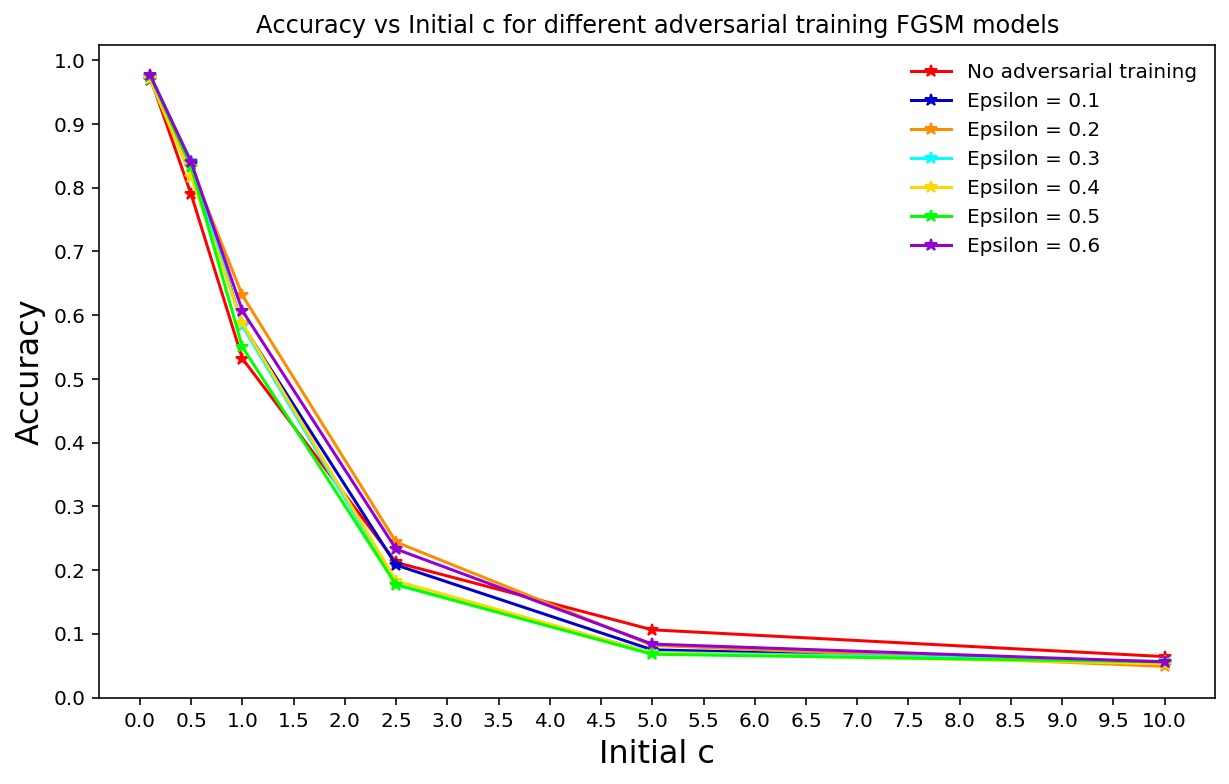

In [52]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'mediumblue', 'darkorange', 'aqua', 'gold', 'lime', 'darkviolet']

for idx, (title, results) in enumerate(adv_fgsm_train.items()):
    plt.plot(constants, results, "*-", color=colors[idx], label="{}".format(title))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 10.1, step=0.5))
plt.title("Accuracy vs Initial c for different adversarial training FGSM models")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

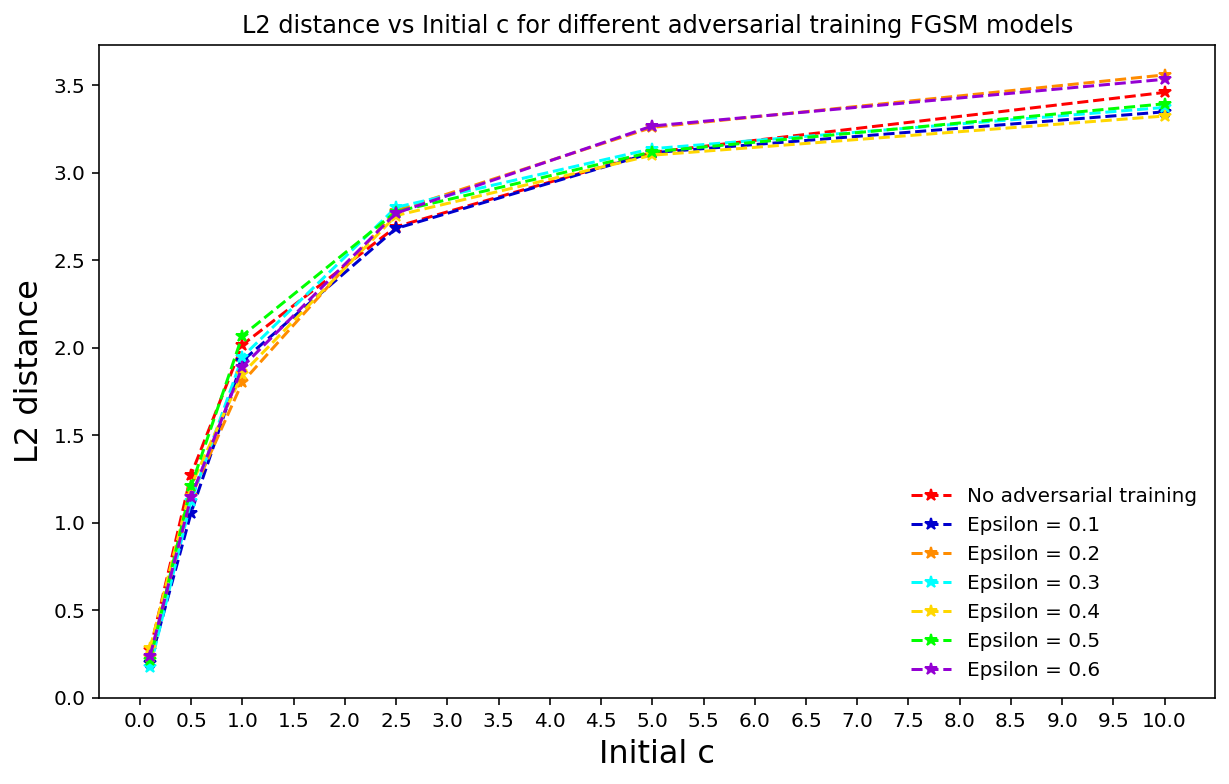

In [53]:
# plot the distances vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'mediumblue', 'darkorange', 'aqua', 'gold', 'lime', 'darkviolet']

for idx, (title, results) in enumerate(adv_fgsm_dist.items()):
    plt.plot(constants, results, "*--", color=colors[idx], label="{}".format(title))

plt.yticks(np.arange(0, 3.6, step=0.5))
plt.xticks(np.arange(0, 10.5, step=0.5))
plt.title("L2 distance vs Initial c for different adversarial training FGSM models")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='lower right', frameon=False)
plt.show()

### LInf

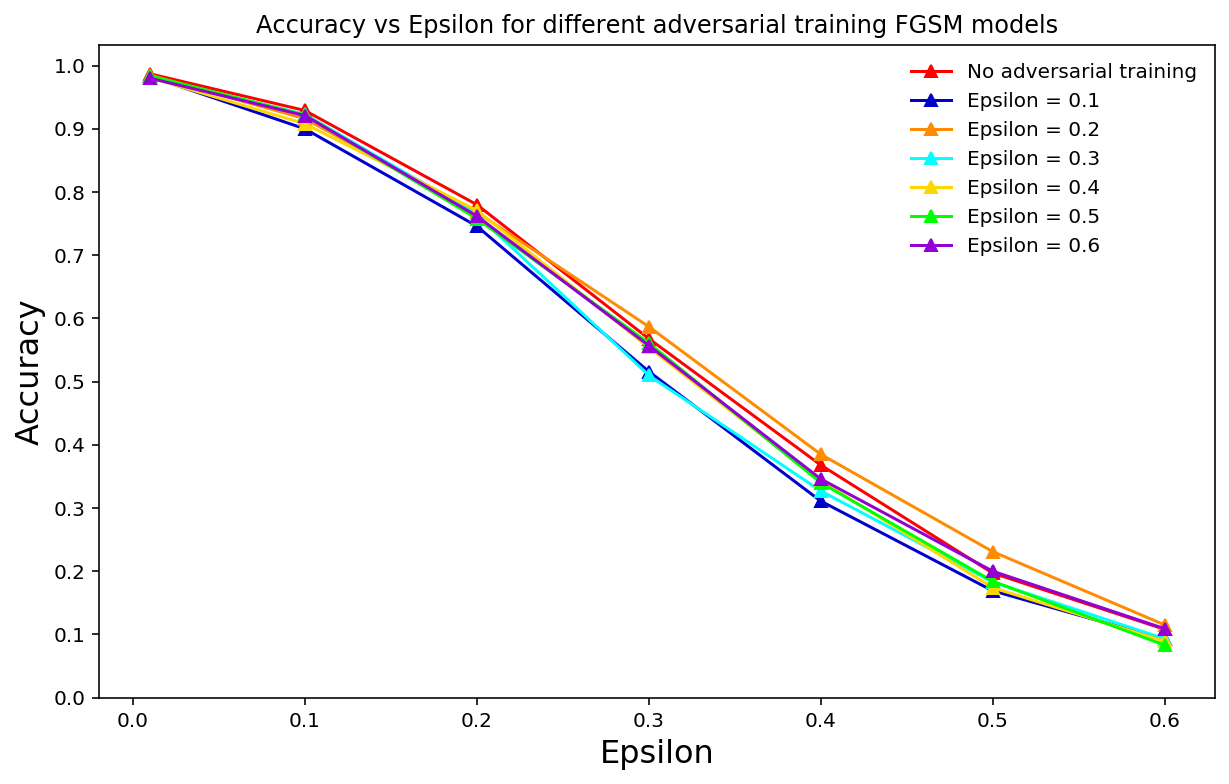

In [54]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['red', 'mediumblue', 'darkorange', 'aqua', 'gold', 'lime', 'darkviolet']

for idx, (title, results) in enumerate(adv_fgsm_eps.items()):
    plt.plot(epsilons, results, "^-", color=colors[idx], label="{}".format(title))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.61, step=0.1))
plt.title("Accuracy vs Epsilon for different adversarial training FGSM models")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()